In [1]:
from matplotlib import pyplot as plt
import pickle
import os
import json
import numpy as np
import pandas as pd
from matplotlib.colors import Normalize
import matplotlib.colors as colors
from scipy import stats
import matplotlib
import progressbar
import datetime
import ooipy
from ooipy import Spectrogram

font = {'size'   : 22}
matplotlib.rc('font', **font)

# Function for computing spectral PDFs from raw data

In [2]:
def get_spdf(spec_like, fs_hz, fmax=None, spl_bins=np.linspace(0, 120, 481),
             percentiles=[1, 5, 10, 50, 90, 95, 99]):
    """
    spec_like : Spectrogram like object. Accaptable are ooipy.Spectrogram or a dictionary
        with keys "time", "freq", and "values"
    fs_hz : sampling frequency in Hz
    fmax : frequency up to which spectral PDF is computed
    spl_bins : bins for spectral level
    percentiles : percentiles that will be computed along with the PDF
    """
    
    if isinstance(spec_like, Spectrogram):
        time = spec_like.time
        freq = spec_like.freq
        values = spec_like.values
    elif isinstance(spec_like, dict):
        try:
            time = spec_like['time']
            freq = spec_like['freq']
            values = spec_like['values']
        except:
            print('spec_like must be either ooipy.Spectrogram object or dictionary with keys "time", "freq", and "values"')
            
    else:
        print('spec_like must be either ooipy.Spectrogram object or dictionary with keys "time", "freq", and "values"')
        
    
    
    dct_category = {'data': [], 'cnt': 0, 'starttime': [], 'endtime': [], 'windspeed': [], 'windangle': []}
    
    if fmax is None:
        fmax = freq[-1]
    
    n_freq_bin = int(len(freq) * fmax/(fs_hz/2)) + 1
    
    bar = progressbar.ProgressBar(maxval=n_freq_bin, \
    widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    bar.start()
    
    spdf_dct = {'freq': np.array(np.linspace(0, fmax, n_freq_bin)),
                'spl': spl_bins[:-1],
                'pdf': np.empty((n_freq_bin, 480)),
                'mean': np.empty(n_freq_bin),
                'number_psd': len(time)}
    
    for p in percentiles:
        spdf_dct[str(p)] = np.empty(n_freq_bin)             

    for idx, freq_bin in enumerate(values.transpose()[:n_freq_bin - 1]):
        hist, bin_edges = np.histogram(freq_bin, bins=spl_bins, density=True)
        spdf_dct['pdf'][idx] = hist
        spdf_dct['50'][idx] = np.median(freq_bin)
        spdf_dct['mean'][idx] = np.mean(freq_bin)
        for p in percentiles:
            spdf_dct[str(p)][idx] = np.quantile(freq_bin, p/100)
        bar.update(idx + 1)
        
    bar.finish()
    return spdf_dct

## Plot spectral PDF and percentiles

In [3]:
# getting test data
start = datetime.datetime(2019,1,12,2,30,0)
end = datetime.datetime(2019,1,12,3,30,0)
data = ooipy.get_acoustic_data(start, endtime=end, node='LJ01C')

In [4]:
# computing spectrogram
spec = data.compute_spectrogram_mp(n_process=3, avg_time=1.0)

In [5]:
# computing spectral PDF
spdf = get_spdf(spec, 64000, fmax=26000)

[========================================================================] 100%


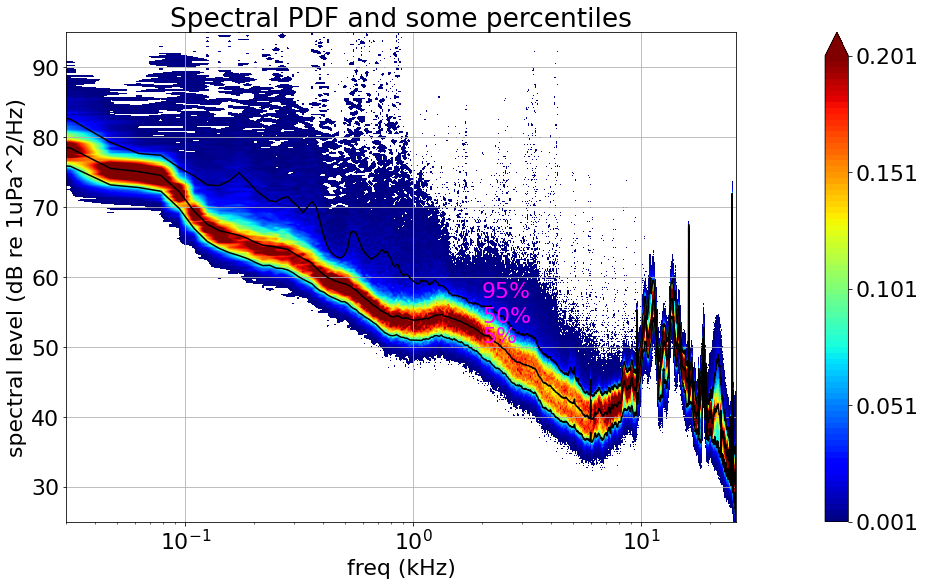

In [6]:
#plotting spectral pdf and some percentiles:
vmin = 0.001 # min probability density
vmax = 0.20 # max probability density
vdelta = 0.0025
cbarticks = np.arange(vmin,vmax+vdelta,vdelta)
fig, ax = plt.subplots(figsize=(16,9))
im = ax.contourf(spdf['freq']/1000, spdf['spl'], np.transpose(spdf['pdf']),
                 cbarticks, norm=colors.Normalize(vmin=vmin, vmax=vmax),
                 cmap='jet', extend='max')

# plot some percentiles:
plt.plot(spdf['freq']/1000, spdf['50'], color='black')
plt.annotate('50%', xy=(2, spdf['50'][104]), color='magenta')

plt.plot(spdf['freq']/1000, spdf['5'], color='black')
plt.annotate('5%', xy=(2, spdf['5'][104]), color='magenta')

plt.plot(spdf['freq']/1000, spdf['95'], color='black')
plt.annotate('95%', xy=(2, spdf['95'][104]), color='magenta')

plt.ylabel('spectral level (dB re 1uPa^2/Hz)')
plt.xlabel('freq (kHz)')
plt.ylim([25,95])
plt.xlim([0.03, 26])
plt.xscale('log')
plt.colorbar(im, ax=ax, ticks=np.arange(vmin, vmax+vdelta, 0.05),  pad=0.1)
plt.tick_params(axis='y')
plt.grid(True)
plt.title('Spectral PDF and some percentiles')
plt.show()